In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


In [ ]:
data = pd.read_csv("/content/dataset_full (1).csv")
print("Dataset shape:", data.shape)
print(data.head())

data = data.dropna().drop_duplicates()

boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params',
                   'domain_spf', 'tls_ssl_certificate', 'url_google_index',
                   'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)

numerical_columns = [col for col in data.columns if col not in boolean_columns]

scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])

scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])

joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")
data.to_csv("newphishdata.csv", index=False)


Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   


In [ ]:
X = data.drop(columns=['phishing'])
y = data['phishing']

X_train_dqn, X_test_dqn, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
class NeuralFieldAttention(Layer):
    def __init__(self, timesteps=10, lambda_strength=0.1, **kwargs):
        super(NeuralFieldAttention, self).__init__(**kwargs)
        self.timesteps = timesteps
        self.lambda_strength = lambda_strength

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='interaction_kernel'
        )
        super(NeuralFieldAttention, self).build(input_shape)

    def call(self, inputs):
        I = inputs
        u = tf.zeros_like(I)

        for _ in range(self.timesteps):
            interaction = tf.matmul(I, self.kernel)
            activation = tf.nn.relu(u)
            delta = tf.reduce_mean(tf.abs(I - tf.reduce_mean(I, axis=1, keepdims=True)), axis=-1, keepdims=True)
            delta = tf.tile(delta, [1, 1, inputs.shape[-1]])
            u = u + (-u + interaction + I + self.lambda_strength * delta)

        attention_scores = tf.nn.softmax(u, axis=1)
        attended_output = tf.reduce_sum(attention_scores * inputs, axis=1)
        return attended_output

    def get_config(self):
        config = super(NeuralFieldAttention, self).get_config()
        config.update({
            'timesteps': self.timesteps,
            'lambda_strength': self.lambda_strength
        })
        return config


In [ ]:
from tensorflow.keras.layers import Reshape

dqn_attention_model = Sequential()

# Reshape input to match attention input shape: (batch_size, timesteps=1, features)
dqn_attention_model.add(Input(shape=(111,)))
dqn_attention_model.add(Reshape((1, 111)))

# Neural Field Attention Layer
dqn_attention_model.add(NeuralFieldAttention(timesteps=5, lambda_strength=0.2))

# Fully Connected Layers (DQN style)
dqn_attention_model.add(Dense(128, activation='relu'))
dqn_attention_model.add(Dropout(0.2))
dqn_attention_model.add(Dense(64, activation='relu'))
dqn_attention_model.add(Dropout(0.2))
dqn_attention_model.add(Dense(32, activation='relu'))

# Output layer
dqn_attention_model.add(Dense(1, activation='sigmoid'))

# Compile
dqn_attention_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

dqn_attention_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 1, 111)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neural_field_attention_1             │ (None, 111)                 │          12,321 │
│ (NeuralFieldAttention)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,026 (144.63 KB)

 Trainable params: 37,026 (144.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epoch_times = []

def on_epoch_begin(epoch, logs=None):
    global epoch_start_time
    epoch_start_time = time.time()

def on_epoch_end(epoch, logs=None):
    epoch_times.append(time.time() - epoch_start_time)
    print(f"Epoch {epoch+1} Time: {epoch_times[-1]:.2f}s")

time_callback = keras.callbacks.LambdaCallback(
    on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end
)

history_dqn = dqn_attention_model.fit(
    X_train_dqn, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_dqn, y_test),
    callbacks=[early_stopping, time_callback],
    verbose=1
)


Epoch 1/50
2180/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9879 - Precision: 0.9230 - Recall: 0.9267 - accuracy: 0.9475 - loss: 0.1326Epoch 1 Time: 16.75s
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - AUC: 0.9879 - Precision: 0.9230 - Recall: 0.9267 - accuracy: 0.9475 - loss: 0.1326 - val_AUC: 0.9892 - val_Precision: 0.9249 - val_Recall: 0.9408 - val_accuracy: 0.9526 - val_loss: 0.1250
Epoch 2/50
2178/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9880 - Precision: 0.9249 - Recall: 0.9268 - accuracy: 0.9480 - loss: 0.1325Epoch 2 Time: 17.93s
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - AUC: 0.9880 - Precision: 0.9248 - Recall: 0.9268 - accuracy: 0.9480 - loss: 0.1325 - val_AUC: 0.9893 - val_Precision: 0.9206 - val_Recall: 0.9428 - val_accuracy: 0.9516 - val_loss: 0.1257
Epoch 3/50
2179/2181 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9881 - Precision: 0.9230 - Recall: 0.9284 - accuracy: 0.9480 - loss: 0.1309Epoch 3 Time: 18.80s
2181/2181 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - AUC: 0.98

In [ ]:
y_pred_dqn = (dqn_attention_model.predict(X_test_dqn) > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_dqn)
precision = precision_score(y_test, y_pred_dqn)
recall = recall_score(y_test, y_pred_dqn)
auc = roc_auc_score(y_test, y_pred_dqn)
conf_matrix = confusion_matrix(y_test, y_pred_dqn)

print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]
far = fp / (fp + tn)
frr = fn / (fn + tp)
print("\nFAR:", round(far, 4))
print("FRR:", round(frr, 4))


546/546 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Metrics:
Accuracy: 0.9550
Precision: 0.9359
Recall: 0.9354
AUC: 0.9505
Confusion Matrix:
[[10952   391]
 [  394  5705]]

FAR: 0.0345
FRR: 0.0646


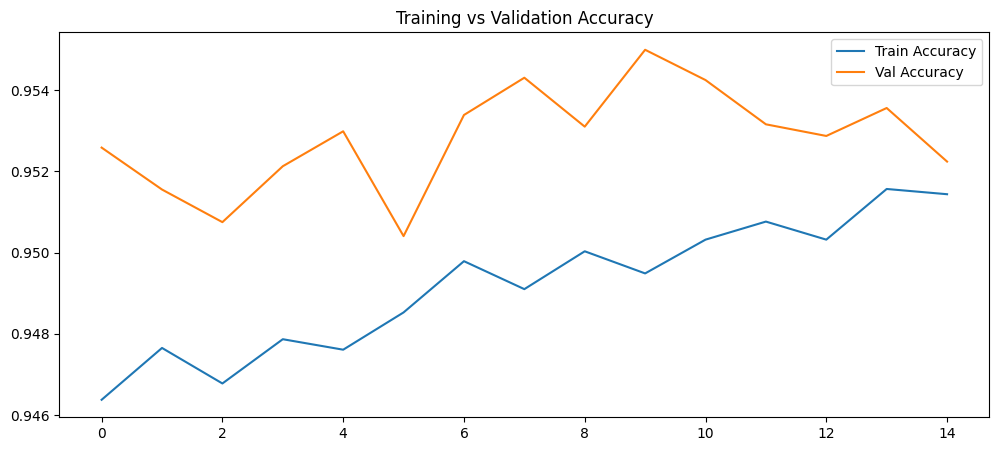

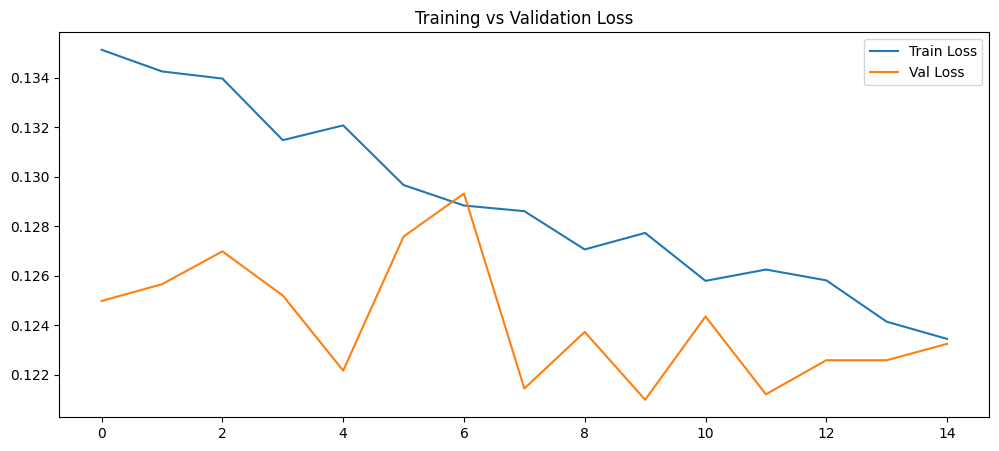

In [ ]:
np.save("model_history_dqn_attention.npy", history_dqn.history)

plt.figure(figsize=(12, 5))
plt.plot(history_dqn.history['accuracy'], label='Train Accuracy')
plt.plot(history_dqn.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history_dqn.history['loss'], label='Train Loss')
plt.plot(history_dqn.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()
